## Requisitos

In [20]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install nvidia-cudnn-cu12
!pip install Pillow
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

# Rodar um 
# conda install -c conda-forge cudatoolkit

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/vinmelo/Documents/Deep-

## Carregando os dados

### Data Augmentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2,
    horizontal_flip = True,
    vertical_flip = False
)
datagen_valid = ImageDataGenerator(
    samplewise_center=True,
    validation_split=0.2
)

Para avaliar os diferentes tipos de filtro, vamos carregar o data set de 7 formas:
- Variando cada crop com uma técnica de filtro
- Crop sem background

In [23]:
dir_used = ["crop_and_laplacian","crop_and_canny","crop_and_clahe","crop_and_scharr","crop_and_sharpening","crop_only", "removed_bg"]

train_dt = [datagen_train.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="training",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

valid_dt = [datagen_valid.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="validation",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


## Modelo para Side
### Importando o Modelo pré treinado

In [24]:
from tensorflow import keras
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

Congelando as primeiras camadas para treinarmos apenas as camada finais

In [25]:
base_model.trainable = False

### Adicionando camadas e compilando

In [26]:
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)

models = [keras.Model(inputs,outputs) for i in range(7)]
models

[<Functional name=functional_7, built=True>,
 <Functional name=functional_8, built=True>,
 <Functional name=functional_9, built=True>,
 <Functional name=functional_10, built=True>,
 <Functional name=functional_11, built=True>,
 <Functional name=functional_12, built=True>,
 <Functional name=functional_13, built=True>]

In [27]:
for i in range(7):
    models[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo para cada tipo de imagem

In [28]:
for i in range(7):
    models[i].fit(train_dt[i],
          validation_data=valid_dt[i],
          epochs=50)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-07-10 14:39:56.699484: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:39:56.893806: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:39:57.591990: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:39:57.782433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:39:58.592872: E external/local_xla/xla/stream_

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - AUC: 0.5121 - Precision: 0.5251 - Recall: 0.3390 - accuracy: 0.5174 - loss: 0.7063

2025-07-10 14:40:13.385576: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:13.553762: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:14.131836: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:14.311964: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:15.060368: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.5089 - Precision: 0.5152 - Recall: 0.3948 - accuracy: 0.5090 - loss: 0.7095 

2025-07-10 14:40:32.734174: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:32.885088: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:33.399737: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:33.568210: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:40:34.285441: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - AUC: 0.5071 - Precision: 0.5113 - Recall: 0.4007 - accuracy: 0.5064 - loss: 0.7104 - val_AUC: 0.6049 - val_Precision: 0.7273 - val_Recall: 0.4444 - val_accuracy: 0.6389 - val_loss: 0.6756
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - AUC: 0.4323 - Precision: 0.3551 - Recall: 0.2517 - accuracy: 0.4341 - loss: 0.7413 - val_AUC: 0.6713 - val_Precision: 0.5152 - val_Recall: 0.9444 - val_accuracy: 0.5278 - val_loss: 0.6777
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - AUC: 0.6102 - Precision: 0.5747 - Recall: 0.5663 - accuracy: 0.5756 - loss: 0.6735 - val_AUC: 0.6759 - val_Precision: 0.5333 - val_Recall: 0.8889 - val_accuracy: 0.5556 - val_loss: 0.6711
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - AUC: 0.6599 - Precision: 0.6059 - Recall: 0.5090 - accuracy: 0.6234 - loss: 0.6614 - val_AUC: 0.6759 - val_Precision: 0.5312 - val_Recall: 0.9444 - val_accuracy: 0.5556 - val_loss: 0.6726
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - A

2025-07-10 14:52:06.245093: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:06.409849: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:06.968789: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:07.147735: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:07.881608: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8981 - Precision: 0.8477 - Recall: 0.8741 - accuracy: 0.8428 - loss: 0.4270 

2025-07-10 14:52:24.309031: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:24.462086: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:24.960677: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:25.130153: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 14:52:25.792139: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - AUC: 0.9029 - Precision: 0.8487 - Recall: 0.8766 - accuracy: 0.8467 - loss: 0.4161 - val_AUC: 0.9395 - val_Precision: 0.8500 - val_Recall: 0.9444 - val_accuracy: 0.8857 - val_loss: 0.3249
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - AUC: 0.9426 - Precision: 0.9295 - Recall: 0.8758 - accuracy: 0.8953 - loss: 0.3083 - val_AUC: 0.9412 - val_Precision: 0.8500 - val_Recall: 0.9444 - val_accuracy: 0.8857 - val_loss: 0.3164
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - AUC: 0.9442 - Precision: 0.9090 - Recall: 0.9181 - accuracy: 0.9115 - loss: 0.3029 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3183
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - AUC: 0.9120 - Precision: 0.8429 - Recall: 0.8747 - accuracy: 0.8602 - loss: 0.3658 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3119
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - A

### Avaliando os modelos

#### Acurácia

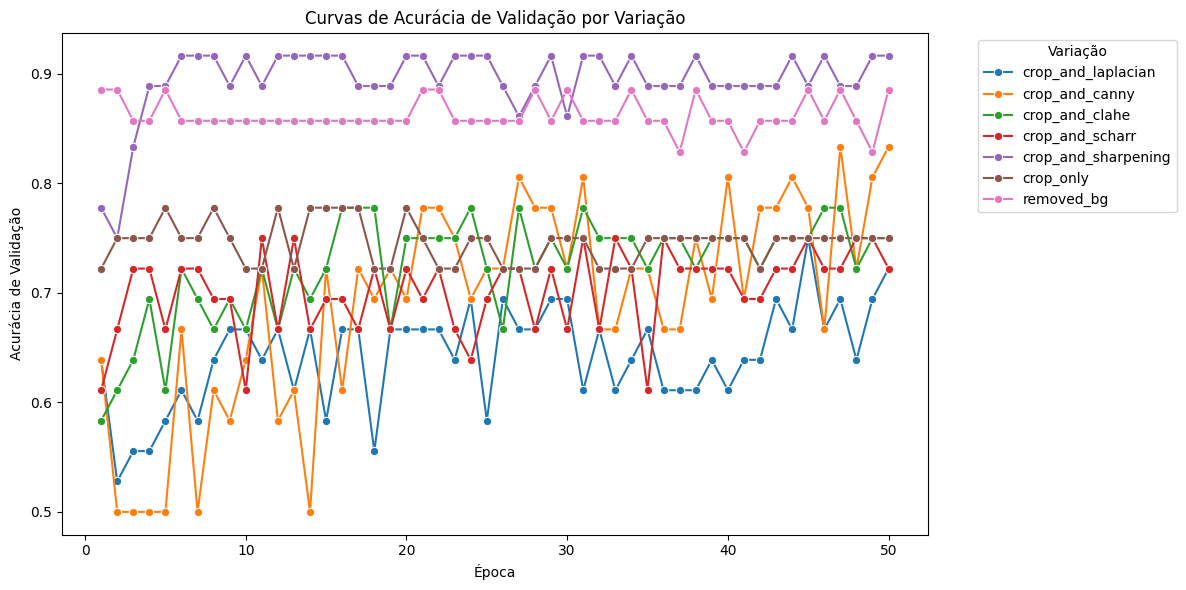

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### AUC (Area under the curve)

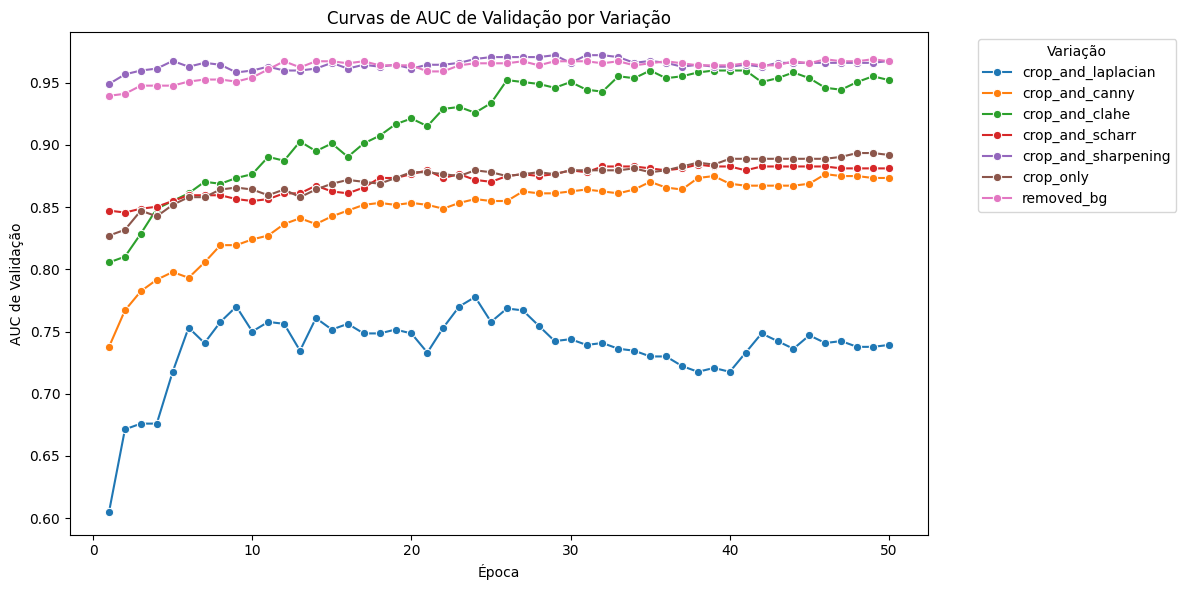

In [30]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de AUC de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("AUC de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Precision

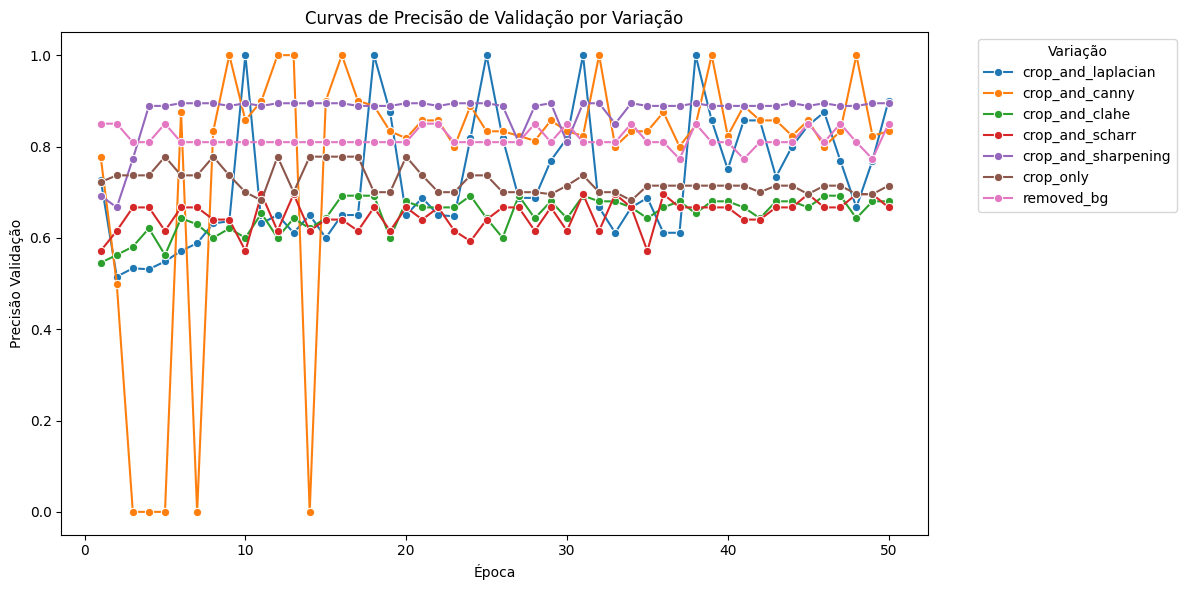

In [31]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precisão de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precisão Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recall

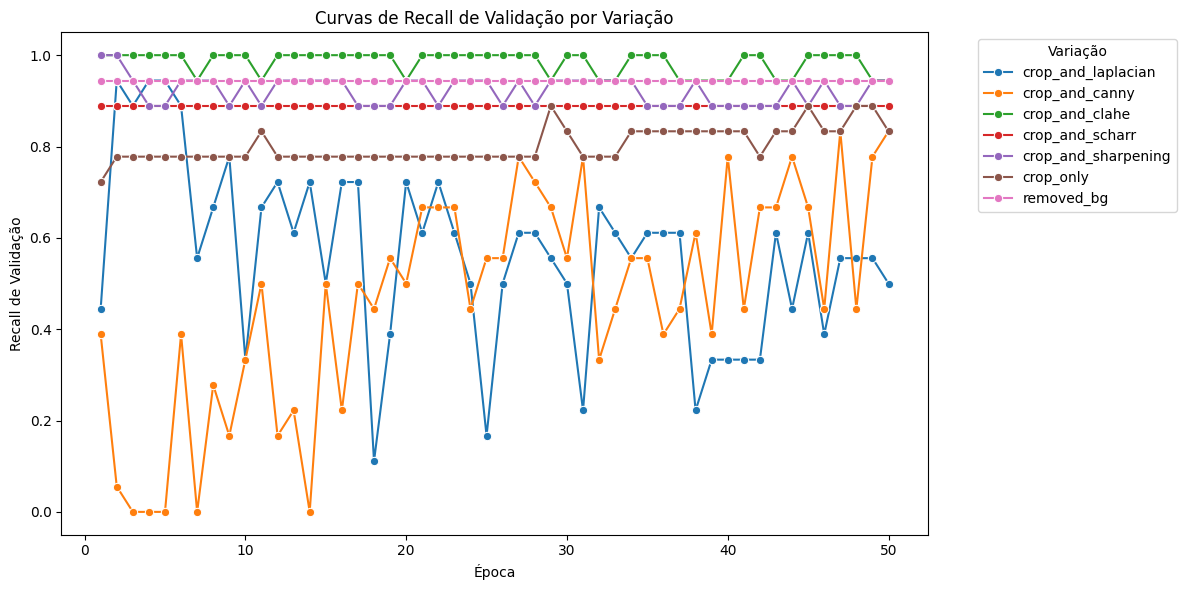

In [32]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
models[4].history.history['val_accuracy'][-1]
models[4].save('side-transfer.keras')
models[6].save('side-teste.keras')

#### Matriz de confusão

Como o modelo funcionou melhor com crop_and_sharpening, vamos fazer a matriz de confusão
apenas com esse pré processamento

Processando 2 batches...
Batch 1/2 processado
Batch 2/2 processado


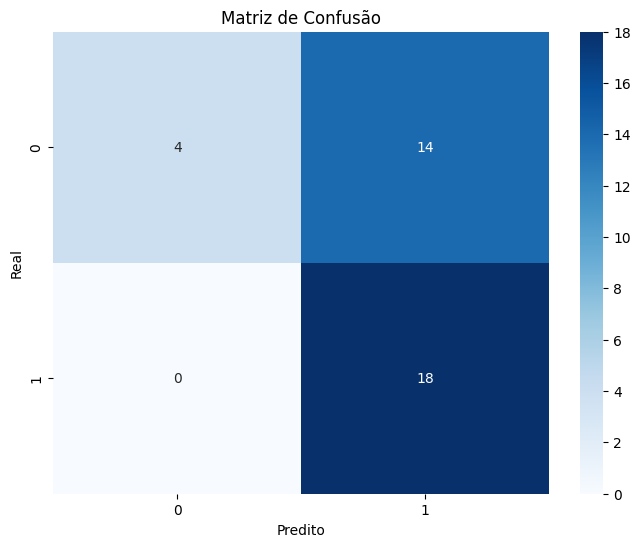

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.56      1.00      0.72        18

    accuracy                           0.61        36
   macro avg       0.78      0.61      0.54        36
weighted avg       0.78      0.61      0.54        36



In [24]:
import tensorflow as tf
import os

# Limpar e reconfigurar TensorFlow
tf.keras.backend.clear_session()

# Forçar CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Reiniciar o ambiente TensorFlow
import importlib
importlib.reload(tf)

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Carregue o modelo
model_sharpening = models[4]

# Processar batch por batch para evitar problemas de memória
selected_iterator = valid_dt[4]
all_predictions = []
all_true_labels = []

print(f"Processando {len(selected_iterator)} batches...")

for i in range(len(selected_iterator)):
    try:
        # Pegar um batch por vez
        batch_images, batch_labels = selected_iterator[i]
        
        # Predição
        batch_pred_probs = model_sharpening.predict(batch_images, batch_size=1, verbose=0)
        batch_pred = (batch_pred_probs > 0.5).astype("int").flatten()
        
        # Armazenar resultados
        all_predictions.extend(batch_pred)
        all_true_labels.extend(batch_labels.astype("int").flatten())
        
        print(f"Batch {i+1}/{len(selected_iterator)} processado")
        
    except Exception as e:
        print(f"Erro no batch {i}: {e}")
        continue

# Converter para arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Matriz de confusão
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print(classification_report(all_true_labels, all_predictions))

In [34]:
models[4].save('transfer-learning_side.keras')

## Modelo para top

### Importando o modelo VGG16

In [4]:
from tensorflow import keras

base_model_top = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

base_model_top.trainable = False

I0000 00:00:1752166622.165980   81431 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1403 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:05:00.0, compute capability: 7.5


### Adicionando camadas e compilando

In [5]:
inputs_top = keras.Input(shape=(224,224,3))

x_top = base_model_top(inputs_top, training=False)
x_top = keras.layers.GlobalAveragePooling2D()(x_top)

outputs_top = keras.layers.Dense(1, activation= 'sigmoid')(x_top)

models_top = [keras.Model(inputs_top,outputs_top) for i in range(7)]
models_top

[<Functional name=functional, built=True>,
 <Functional name=functional_1, built=True>,
 <Functional name=functional_2, built=True>,
 <Functional name=functional_3, built=True>,
 <Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>,
 <Functional name=functional_6, built=True>]

In [6]:
for i in range(7):
    models_top[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo

In [9]:
for i in range(7):
    models_top[i].fit(train_dt[i],
              validation_data=valid_dt[i],
              epochs=50)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752166822.912173   82238 service.cc:152] XLA service 0x7009dc00df50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752166822.912197   82238 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-10 14:00:22.964957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752166823.333017   82238 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-10 14:00:24.354704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.5562 - Precision: 0.5306 - Recall: 0.9173 - accuracy: 0.5280 - loss: 3.2005

2025-07-10 14:00:48.706124: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:00:48.934098: I external/local_xla/xla/service/

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.5556 - Precision: 0.5245 - Recall: 0.8894 - accuracy: 0.5224 - loss: 3.0291   

2025-07-10 14:01:05.605815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.1203, f32[64,3,3,3]{3,2,1,0} %bitcast.1210, f32[64]{0} %bitcast.1212), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:01:06.084449: I external/local_xla/xla/service/gp

5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - AUC: 0.5551 - Precision: 0.5204 - Recall: 0.8708 - accuracy: 0.5187 - loss: 2.9148 - val_AUC: 0.5540 - val_Precision: 0.5385 - val_Recall: 0.7778 - val_accuracy: 0.5556 - val_loss: 1.3341
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - AUC: 0.5252 - Precision: 0.5188 - Recall: 0.4894 - accuracy: 0.5392 - loss: 1.4006 - val_AUC: 0.5772 - val_Precision: 0.5517 - val_Recall: 0.8889 - val_accuracy: 0.5833 - val_loss: 1.3926
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - AUC: 0.6398 - Precision: 0.5784 - Recall: 0.6072 - accuracy: 0.5848 - loss: 1.0434 - val_AUC: 0.6096 - val_Precision: 0.5517 - val_Recall: 0.8889 - val_accuracy: 0.5833 - val_loss: 1.3431
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - AUC: 0.6385 - Precision: 0.5801 - Recall: 0.6341 - accuracy: 0.5787 - loss: 1.0283 - val_AUC: 0.6343 - val_Precision: 0.5769 - val_Recall: 0.8333 - val_accuracy: 0.6111 - val_loss: 1.0787
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - A

2025-07-10 14:17:59.597123: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:17:59.839186: I external/local_xla/xla/servic

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8925 - Precision: 0.8747 - Recall: 0.7129 - accuracy: 0.8159 - loss: 0.4759 

2025-07-10 14:18:25.539338: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.46 = (f32[3,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,256,28,28]{3,2,1,0} %bitcast.1305, f32[512,256,3,3]{3,2,1,0} %bitcast.1312, f32[512]{0} %bitcast.1314), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/vgg16_1/block4_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:18:27.489632: I external/local_xla/xla/servi

5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - AUC: 0.8978 - Precision: 0.8759 - Recall: 0.7330 - accuracy: 0.8231 - loss: 0.4590 - val_AUC: 0.9069 - val_Precision: 0.7083 - val_Recall: 0.9444 - val_accuracy: 0.7714 - val_loss: 0.5100
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 993ms/step - AUC: 0.9050 - Precision: 0.8123 - Recall: 0.8657 - accuracy: 0.8242 - loss: 0.4127 - val_AUC: 0.9150 - val_Precision: 0.7391 - val_Recall: 0.9444 - val_accuracy: 0.8000 - val_loss: 0.4469
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - AUC: 0.9237 - Precision: 0.8046 - Recall: 0.8670 - accuracy: 0.8278 - loss: 0.3780 - val_AUC: 0.9167 - val_Precision: 0.7391 - val_Recall: 0.9444 - val_accuracy: 0.8000 - val_loss: 0.4564
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step - AUC: 0.9259 - Precision: 0.8450 - Recall: 0.8383 - accuracy: 0.8365 - loss: 0.3641 - val_AUC: 0.9248 - val_Precision: 0.8947 - val_Recall: 0.9444 - val_accuracy: 0.9143 - val_loss: 0.3851
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - A

### Acurácia

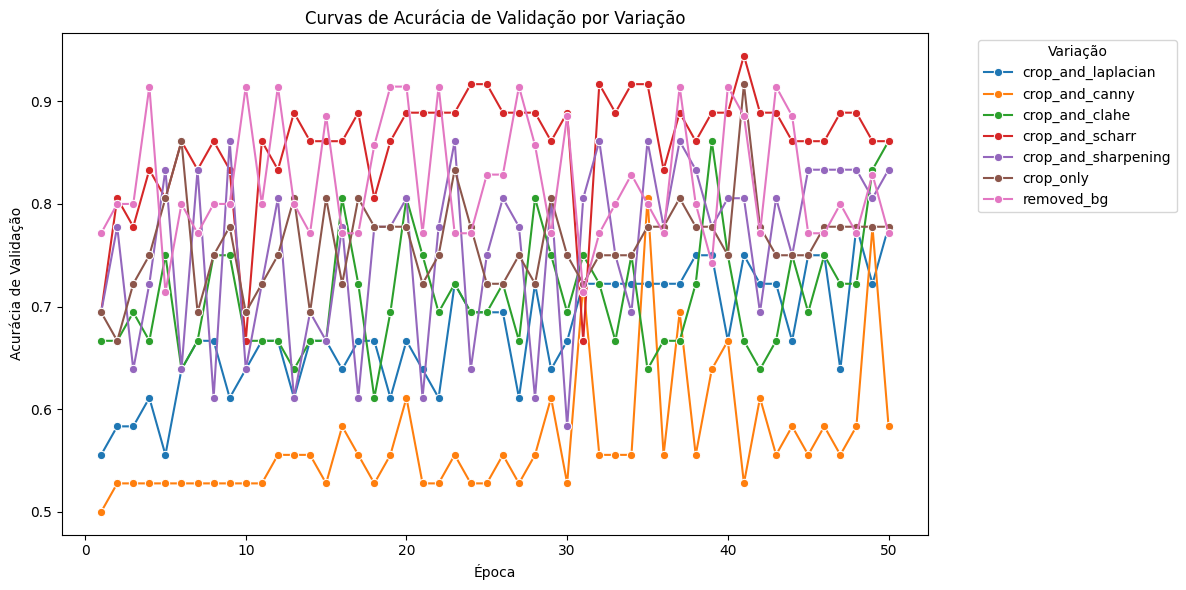

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AUC

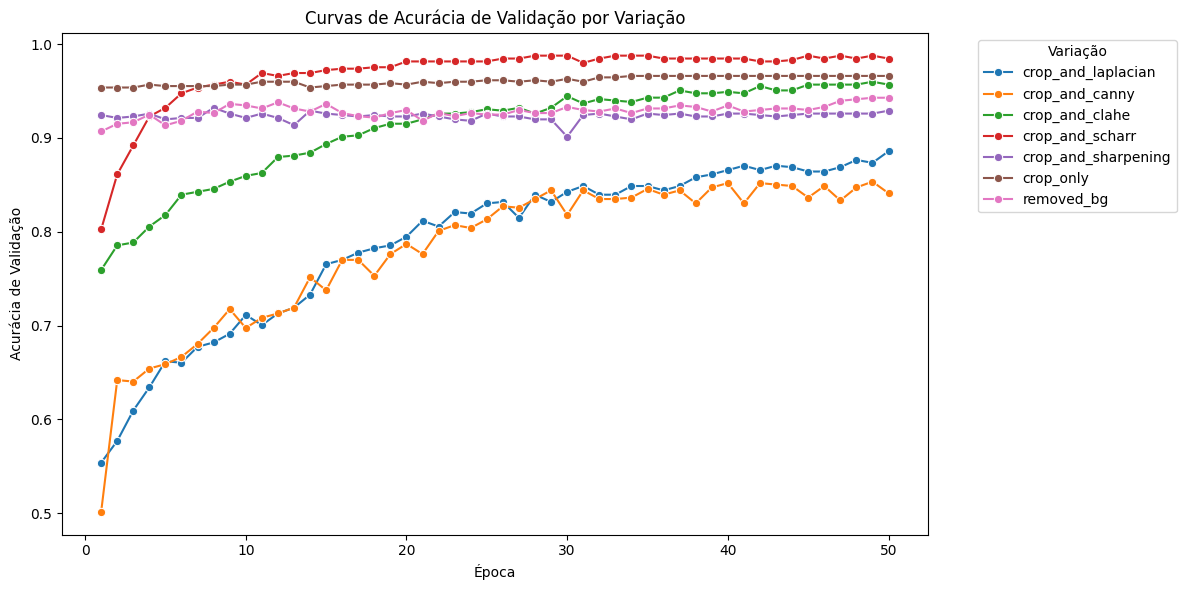

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Precision

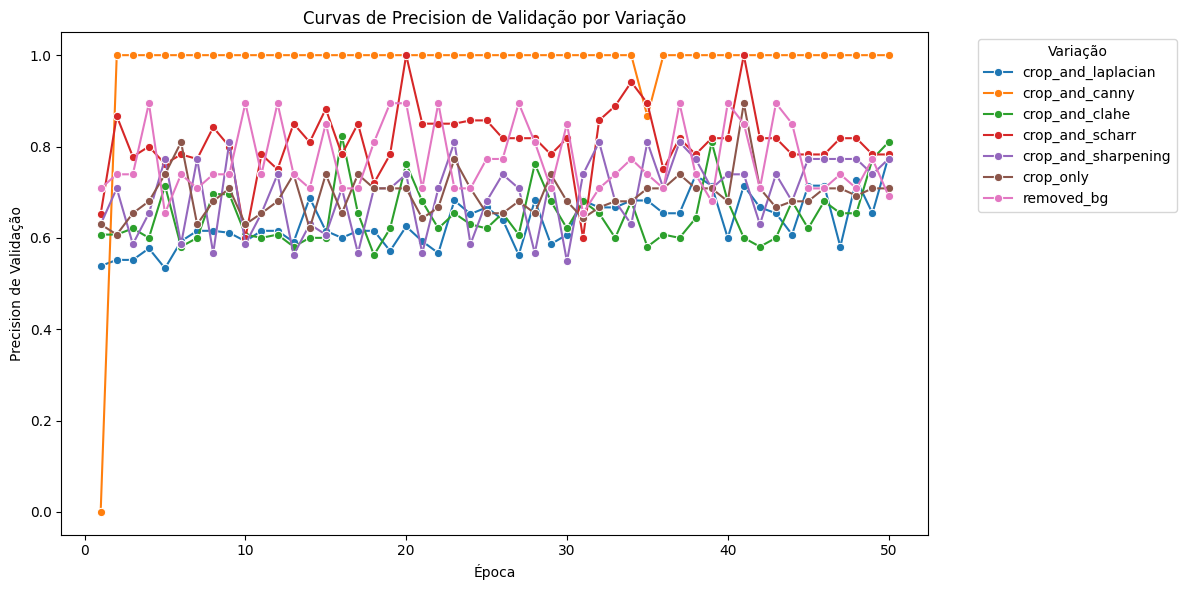

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precision de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precision de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Recall

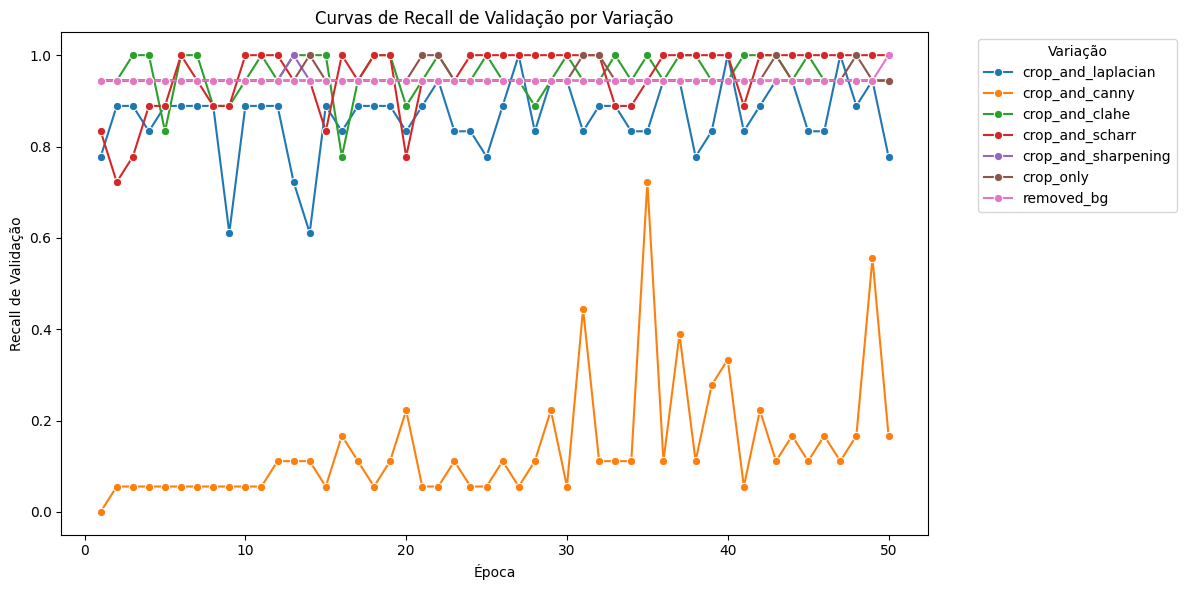

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
models_top[3].save('transfer-learning_top.keras')